In [7]:
import numpy as np
import xarray as xr
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


class ResBlock(nn.Module):
    def __init__(self, hidden_dim=128, kernel_size=3, activation=nn.ReLU()):
        super(ResBlock, self).__init__()
        conv_settings = dict(kernel_size=kernel_size, padding=(kernel_size-1)//2, padding_mode='replicate')
        self.sequential = nn.Sequential(
            nn.Conv1d(hidden_dim, hidden_dim, **conv_settings),
            activation,
            nn.Conv1d(hidden_dim, hidden_dim, **conv_settings)
        )
        self.activation = activation

    def forward(self, x):
        return x + self.sequential(x)


class ConvNet(nn.Module):
    def __init__(self, hidden_dim=128, kernel_size=3, activation=nn.ReLU()):
        super(ConvNet, self).__init__()
        conv_settings = dict(kernel_size=kernel_size, padding=(kernel_size-1)//2, padding_mode='replicate')
        self.sequential = nn.Sequential(
            nn.Conv1d(1, hidden_dim, **conv_settings),
            nn.BatchNorm1d(hidden_dim),
            activation,
            ResBlock(hidden_dim, kernel_size, activation),
            nn.BatchNorm1d(hidden_dim),
            activation,
            nn.Conv1d(hidden_dim, hidden_dim//2, **conv_settings),
            activation,
            nn.Conv1d(hidden_dim//2, hidden_dim//4, **conv_settings),
            activation,
            nn.Conv1d(hidden_dim//4, out_channels=1, **conv_settings) 
        )
        self.dtype = self.sequential[0].weight.dtype

    def init_weights(self):
        for layer in self.sequential:
            if hasattr(layer, 'bias') and layer.bias is not None:
                layer.bias.data.fill_(1.)

    def forward(self, x):
        x = x.unsqueeze(1)
        return self.sequential(x).squeeze(1)


def validate_model(model, ds):
    val_data = torch.tensor(ds['u'].values, dtype=model.dtype).to('cuda')
    model.eval()
    with torch.no_grad():
        d_pred = model(val_data).cpu().detach().numpy()
    model.train()
    return np.mean((d_pred - ds['d'].values)**2)


def train_model(model, ds, optimizer, loss_fn, scheduler=None, n_epochs=100, batch_size=None):
    train_loss_arr = np.zeros(n_epochs)
    valid_loss_arr = np.zeros(n_epochs)

    for epoch in range(n_epochs):
        if not batch_size:
            batch_size = len(ds.sample)
        for i in range(0, len(ds), batch_size):
            batch = ds.isel(sample=slice(i, i+batch_size))
            u = torch.tensor(batch['u'].values, dtype=model.dtype).to('cuda')
            d = torch.tensor(batch['d'].values, dtype=model.dtype).to('cuda')
            optimizer.zero_grad()
            d_pred = model(u)
            loss = loss_fn(
                d_pred[3:-3], d[3:-3]
            )
            loss.backward()
            optimizer.step()
        train_loss_arr[epoch] = loss.item()
        valid_loss_arr[epoch] = validate_model(model, ds)
        if scheduler is not None:
            scheduler.step(valid_loss_arr[epoch])
    return train_loss_arr, valid_loss_arr



In [24]:
train_ds = xr.open_dataset('training_data.nc')
val_ds = xr.open_dataset('validation_data.nc')
test_ds = xr.open_dataset('testing_data.nc')

n_epochs = 25_000
max_lr = 8e-3

model = ConvNet(hidden_dim=128, kernel_size=7, activation=nn.ELU()).float().to('cuda')
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, betas=(0.8, 0.95), weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, n_epochs, steps_per_epoch=1)
loss_fn = nn.MSELoss()

train_loss, val_loss = train_model(model, train_ds, optimizer, loss_fn, scheduler, n_epochs=n_epochs)

/home/andrbenn/miniconda3/envs/hydrogen/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Text(0, 0.5, 'MSE Loss')

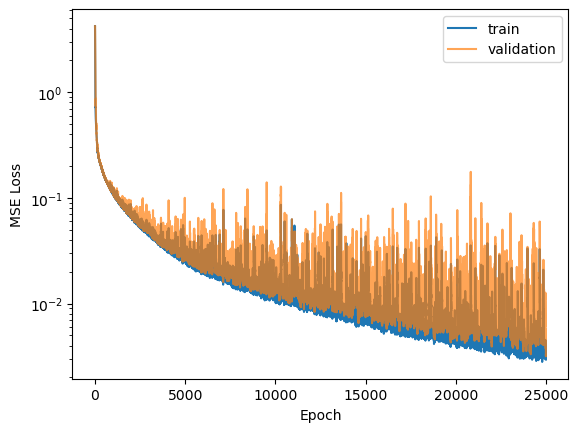

In [28]:
fig, ax = plt.subplots()
ax.plot(train_loss, label='train')
ax.plot(val_loss, label='validation', alpha=0.7)
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')

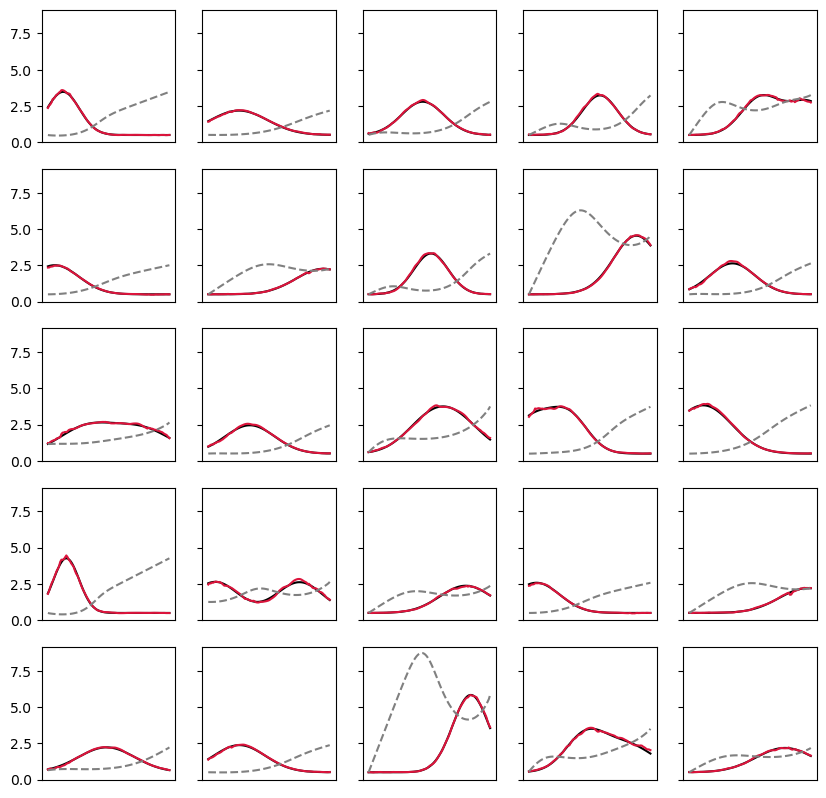

In [29]:
tds = train_ds
test_tensor = torch.tensor(tds['u'].values, dtype=model.dtype).to('cuda')
y_test = model(test_tensor).cpu().detach().numpy()
pred_da = xr.DataArray(y_test, dims=('sample', 'x'))
tds['d_pred'] = pred_da
err_da = (tds['d'] - tds['d_pred'])

fig, axes = plt.subplots(5, 5, figsize=(10, 10), sharex=True, sharey=True)
axes = axes.flatten()

samples = np.linspace(0, 999, len(axes)).astype(int)

for i, ax in zip(samples, axes):
    tds['d'].isel(sample=i).plot(ax=ax, color='black')
    tds['d_pred'].isel(sample=i).plot(ax=ax, color='crimson')
    tds['u'].isel(sample=i).plot(ax=ax, color='grey', linestyle='--')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([])

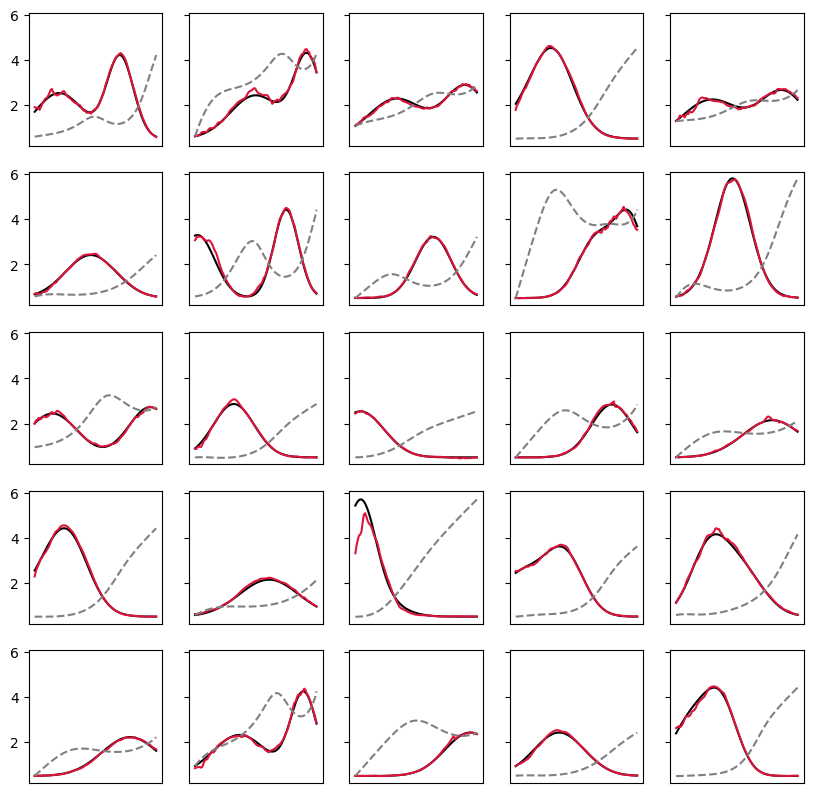

In [30]:
tds = test_ds
test_tensor = torch.tensor(tds['u'].values, dtype=model.dtype).to('cuda')
y_test = model(test_tensor).cpu().detach().numpy()
pred_da = xr.DataArray(y_test, dims=('sample', 'x'))
tds['d_pred'] = pred_da
err_da = (tds['d'] - tds['d_pred'])

fig, axes = plt.subplots(5, 5, figsize=(10, 10), sharex=True, sharey=True)
axes = axes.flatten()

samples = np.linspace(0, 999, len(axes)).astype(int)

for i, ax in zip(samples, axes):
    tds['d'].isel(sample=i).plot(ax=ax, color='black')
    tds['d_pred'].isel(sample=i).plot(ax=ax, color='crimson')
    tds['u'].isel(sample=i).plot(ax=ax, color='grey', linestyle='--')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([])